In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pynucastro as pyna
from scipy.integrate import solve_ivp

# pynucastro

![pynucastro](pynucastro.png)

https://github.com/pynucastro/pynucastro


## What?

pynucastro is a library for interfacing with nuclear reaction rate libraries, interactively exploring reaction rates and networks, and writing the source code needed to integrate a nuclear reaction network.

## Where?

github!  https://github.com/pynucastro/pynucastro

## Why?

no one did a takehome exam problem from my grad *Stars* class of integrating a CNO network.  So I wrote this library for my solutions.



## Defining a network

We'll start with a reaction library downloaded from the JINA ReacLib database (https://reaclib.jinaweb.org/)

In [2]:
rate_library = "20180319default2"

mylibrary = pyna.rates.Library(rate_library)

We'll define the list of nuclei we want in our library.  This should get us H and He burning (via pp and CNO, and 3-alpha)

In [3]:
all_reactants = ["p", "d",
                 "he3", "he4",
                 "c12", "c13",
                 "n13", "n14", "n15",
                 "o14", "o15"]

We'll use that list to filter the library.

There are lots of other ways to filter rates too...

In [4]:
cno = mylibrary.linking_nuclei(all_reactants, with_reverse=False)

In [5]:
print(cno)

n13 --> c13    (n13 --> c13 <wc12_reaclib_weak_>)
o14 --> n14    (o14 --> n14 <wc12_reaclib_weak_>)
o15 --> n15    (o15 --> n15 <wc12_reaclib_weak_>)
p + p --> d    (p + p --> d <bet+_reaclib_weak_>)
p + p --> d    (p + p --> d <ec_reaclib_weak_>)
d + p --> he3    (d + p --> he3 <de04_reaclib__>)
d + d --> he4    (d + d --> he4 <nacr_reaclib__>)
he3 + p --> he4    (he3 + p --> he4 <bet+_reaclib_weak_>)
c12 + p --> n13    (c12 + p --> n13 <ls09_reaclib__>)
c13 + p --> n14    (c13 + p --> n14 <nacr_reaclib__>)
n13 + p --> o14    (n13 + p --> o14 <lg06_reaclib__>)
n14 + p --> o15    (n14 + p --> o15 <im05_reaclib__>)
he3 + d --> p + he4    (he3 + d --> p + he4 <de04_reaclib__>)
n15 + p --> he4 + c12    (n15 + p --> he4 + c12 <nacr_reaclib__>)
he3 + he3 --> p + p + he4    (he3 + he3 --> p + p + he4 <nacr_reaclib__>)
he4 + he4 + he4 --> c12    (he4 + he4 + he4 --> c12 <fy05_reaclib__>)


## Networks

Now we'll create a network that knows how to evaluate the rates, etc.

You can make a python network (that's what we'll do here), a Fortran network (that works with our AMReX-Astro codes), or (soon) a C++ network.

In [6]:
pynet = pyna.PythonNetwork(libraries=[cno])

btw... remember when I said no one did my exam problem.  It's because the data in the library is confusing to interpret.  Here's what it looks like in the library file:

In [7]:
print(pynet.rates[-1].original_source)

8
       he4  he4  he4  c12                  fy05r     7.27500e+00          
-2.435050e+01-4.126560e+00-1.349000e+01 2.142590e+01                      
-1.347690e+00 8.798160e-02-1.316530e+01                                   
8
       he4  he4  he4  c12                  fy05r     7.27500e+00          
-1.178840e+01-1.024460e+00-2.357000e+01 2.048860e+01                      
-1.298820e+01-2.000000e+01-2.166670e+00                                   
8
       he4  he4  he4  c12                  fy05n     7.27500e+00          
-9.710520e-01 0.000000e+00-3.706000e+01 2.934930e+01                      
-1.155070e+02-1.000000e+01-1.333330e+00                                   


## Visualize

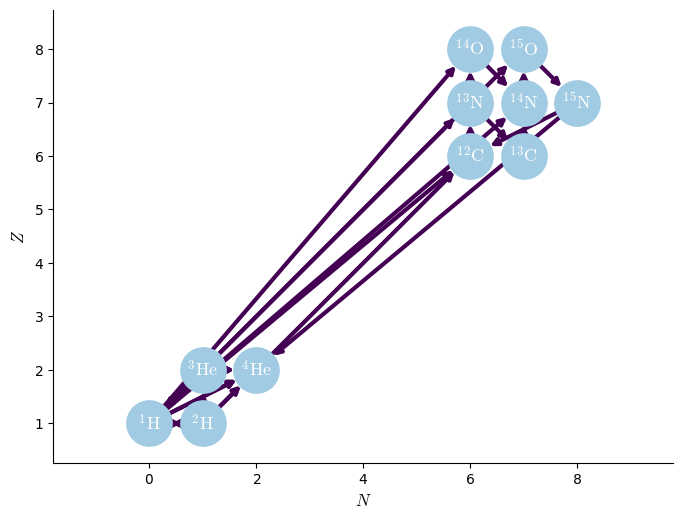

In [8]:
pynet.plot()

## Writing code

pynucastro knows how to output the code to evaluate the rates

In [9]:
print(pynet.function_string(pynet.rates[-1]))

@numba.njit()
def he4_he4_he4__c12(tf):
    # he4 + he4 + he4 --> c12
    rate = 0.0
    
    # fy05r
    rate += np.exp(  -24.3505 + -4.12656*tf.T9i + -13.49*tf.T913i + 21.4259*tf.T913
                  + -1.34769*tf.T9 + 0.0879816*tf.T953 + -13.1653*tf.lnT9)
    # fy05r
    rate += np.exp(  -11.7884 + -1.02446*tf.T9i + -23.57*tf.T913i + 20.4886*tf.T913
                  + -12.9882*tf.T9 + -20.0*tf.T953 + -2.16667*tf.lnT9)
    # fy05n
    rate += np.exp(  -0.971052 + -37.06*tf.T913i + 29.3493*tf.T913
                  + -115.507*tf.T9 + -10.0*tf.T953 + -1.33333*tf.lnT9)
    
    return rate




Now we can output the complete righthand side function needed by an ODE integrator

In [10]:
pynet.write_network("cno_test_integrate.py")

## Integration

We can import our network and use it with SciPy's `solve_ivp`

In [11]:
import cno_test_integrate as cno

We'll set the initial conditions to correspond roughly to the center of the Sun (CGS)

In [12]:
rho = 150
T = 1.5e7

# mass fractions
X0 = np.zeros(cno.nnuc)
X0[cno.ip] = 0.7
X0[cno.ihe4] = 0.28
X0[cno.ic12] = 0.02

# molar fractions
Y0 = X0/cno.A

Reaction nets are stiff, so we'll use BDF

In [13]:
tmax = 1.e20
sol = solve_ivp(cno.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-6)

## Voila

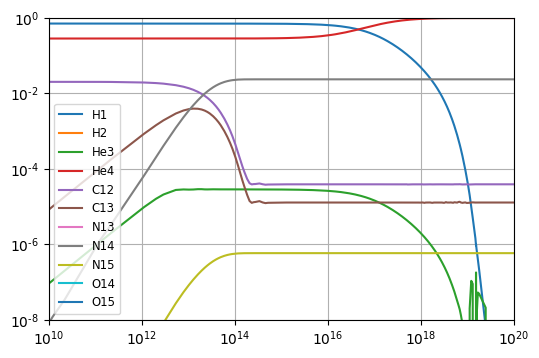

In [14]:
fig, ax = plt.subplots(1)

for n in range(cno.nnuc):
    ax.loglog(sol.t, sol.y[n,:] * cno.A[n], label=f"{cno.names[n].capitalize()}")

ax.set_xlim(1.e10, 1.e20)
ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.grid()